In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk import edit_distance
from pandarallel import pandarallel
import seaborn as sns

pandarallel.initialize(progress_bar=False)

# Set Seaborn theme
sns.set_theme()

def calc_edit_distance(row: pd.Series) -> tuple[int, int]:
    base = edit_distance(row["sentence"], row["error"])

    if row["corrected"] is None:
        return base, base

    return base, edit_distance(row["sentence"], row["corrected"])

def df_calc_edit_distance(df: pd.DataFrame) -> pd.DataFrame:

    print("Calculating edit distances...")
    df[["ED", "ED_corrected"]] = df.parallel_apply(calc_edit_distance, axis=1, result_type="expand")

    return df

def stats(df: pd.DataFrame) -> None:
    print(f"Number of examples: {len(df)}")
    print(f"Average ED original/error: {df['ED'].mean()}")
    print(f"Average ED error/corrected: {df['ED_corrected'].mean()}")


def evaluate(df: pd.DataFrame) -> None:
    df = df_calc_edit_distance(df)

    df_new = df[df['ED_corrected'] <= 10]

    stats(df)
    print("-------------------")
    stats(df_new)

    bins = 20

    # Plot histograms
    _, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Plot for the entire DataFrame - Original ED
    axes[0, 0].hist(df['ED'], bins=bins, color='skyblue', edgecolor='black', alpha=0.5, label='Original ED')
    axes[0, 0].set_title('Entire DataFrame - Original ED')
    axes[0, 0].set_xlabel('Edit Distance')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()

    # Plot for the entire DataFrame - Corrected ED
    axes[0, 1].hist(df['ED_corrected'], bins=bins, color='lightgreen', edgecolor='black', alpha=0.5, label='Corrected ED')
    axes[0, 1].set_title('Entire DataFrame - Corrected ED')
    axes[0, 1].set_xlabel('Edit Distance')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()

    # Plot for the filtered DataFrame (df_new) - Original ED
    axes[1, 0].hist(df_new['ED'], bins=bins, color='skyblue', edgecolor='black', alpha=0.5, label='Original ED')
    axes[1, 0].set_title('Filtered DataFrame (ED_corrected <= 10) - Original ED')
    axes[1, 0].set_xlabel('Edit Distance')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()

    # Plot for the filtered DataFrame (df_new) - Corrected ED
    axes[1, 1].hist(df_new['ED_corrected'], bins=bins, color='lightgreen', edgecolor='black', alpha=0.5, label='Corrected ED')
    axes[1, 1].set_title('Filtered DataFrame (ED_corrected <= 10) - Corrected ED')
    axes[1, 1].set_xlabel('Edit Distance')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Calculating edit distances...
Number of examples: 3886
Average ED original/error: 1.9935666495110653
Average ED error/corrected: 6.065105506948019
-------------------
Number of examples: 3332
Average ED original/error: 1.8358343337334935
Average ED error/corrected: 3.680972388955582


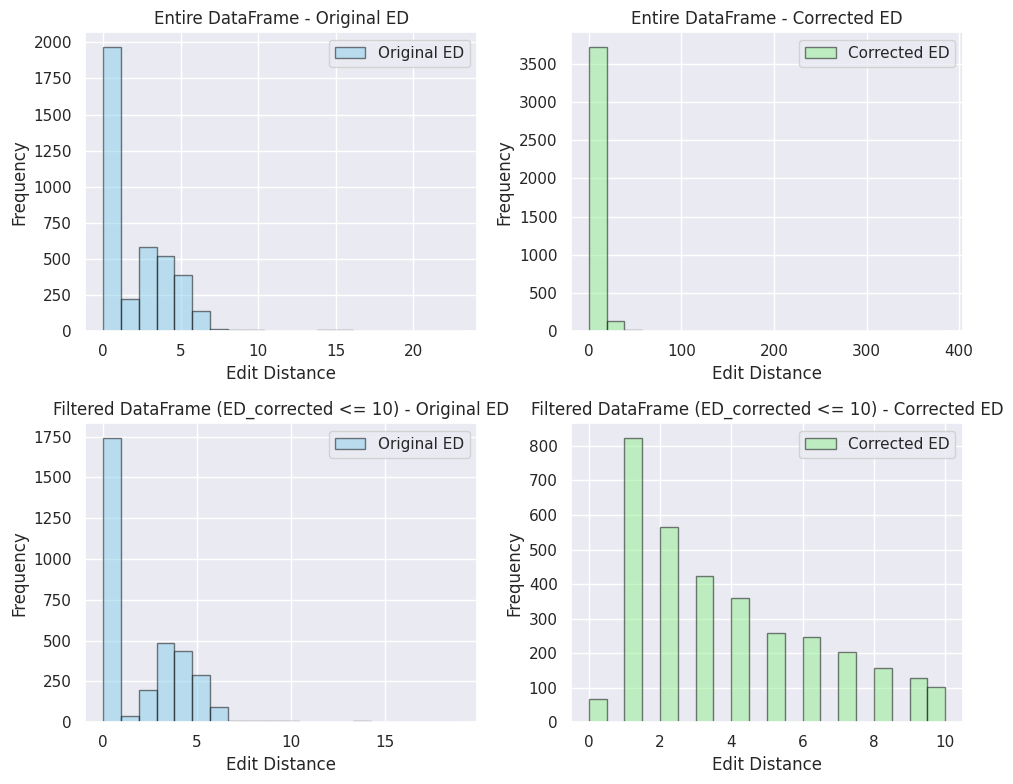

In [45]:
df = pd.read_json("gpt-correction.jsonl", orient="records", lines=True)
evaluate(df)

Calculating edit distances...
Number of examples: 3886
Average ED original/error: 1.9935666495110653
Average ED error/corrected: 2.3903757076685537
-------------------
Number of examples: 3853
Average ED original/error: 1.8948871009602908
Average ED error/corrected: 2.28834674279782


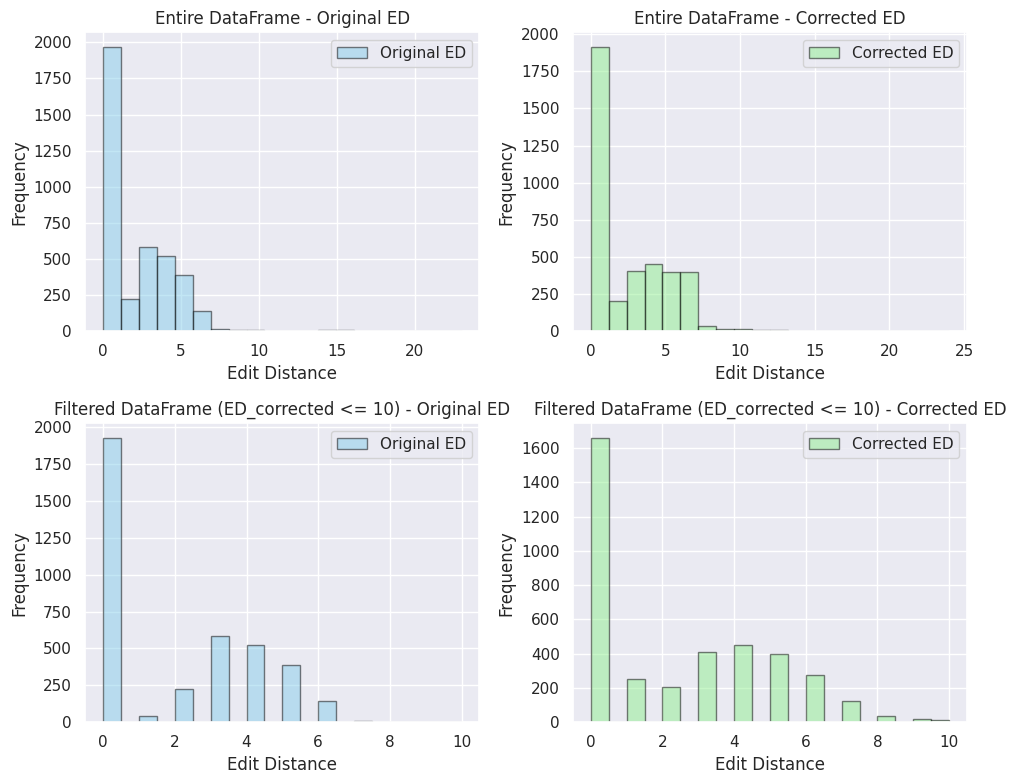

In [46]:
from autocorrect import Speller

spell = Speller('cs', fast=True)

df = pd.read_json("gpt-correction.jsonl", orient="records", lines=True)
df["corrected"] = None
df["corrected"] = df.parallel_apply(lambda row: spell(row["error"]), axis=1)

evaluate(df)

Calculating edit distances...
Number of examples: 3713
Average ED original/error: 1.952060328575276
Average ED error/corrected: 5.712631295448425
-------------------
Number of examples: 2794
Average ED original/error: 1.1066571224051538
Average ED error/corrected: 1.967430207587688


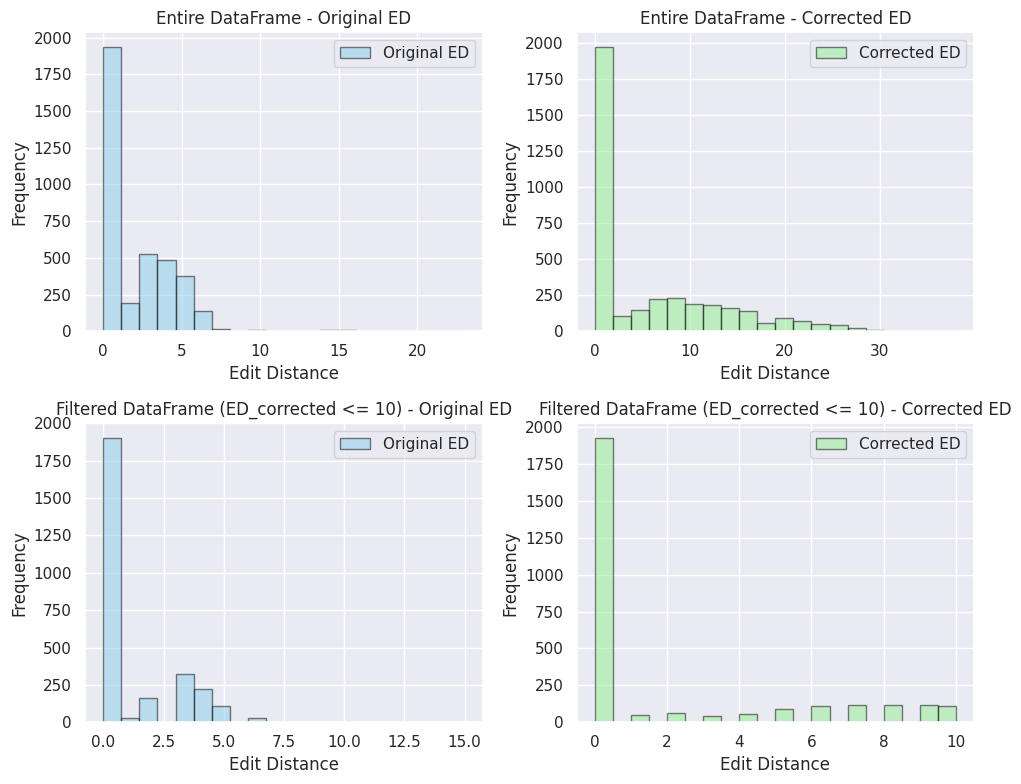

In [47]:
df = pd.read_json(
    "./data/experiment-1.jsonl",
    orient="records",
    lines=True
)

evaluate(df)

Calculating edit distances...
Number of examples: 3713
Average ED original/error: 1.952060328575276
Average ED error/corrected: 3.0201992997576084
-------------------
Number of examples: 3392
Average ED original/error: 1.642688679245283
Average ED error/corrected: 1.958431603773585


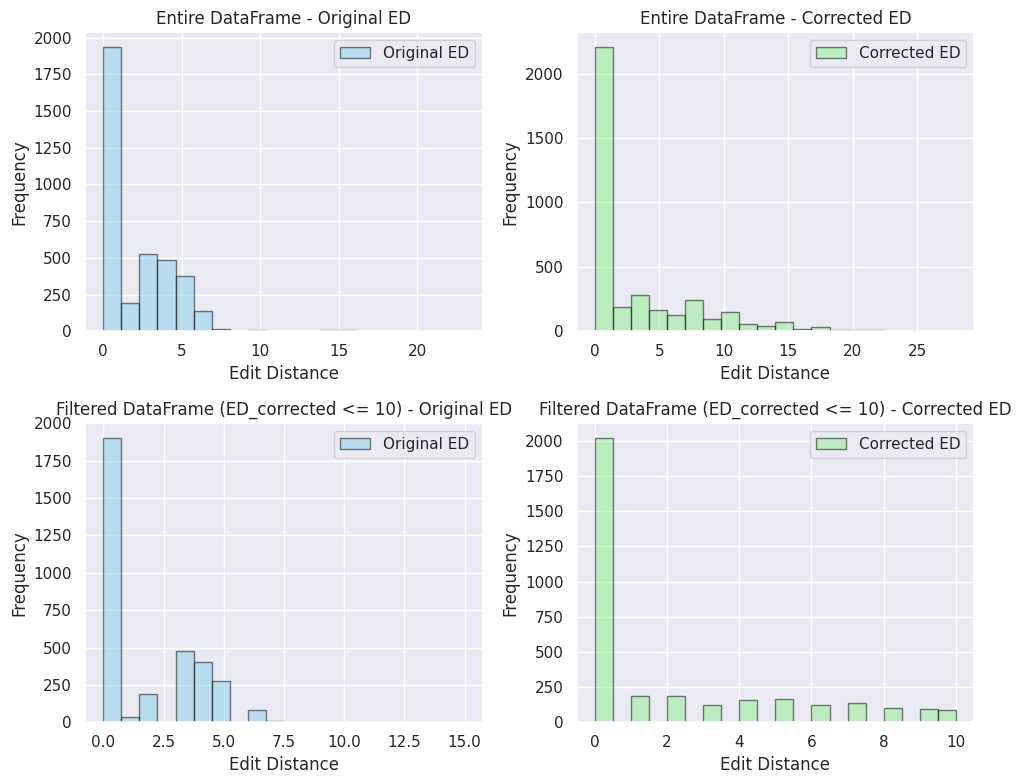

In [48]:
df = pd.read_json(
    "./data/experiment-2.jsonl",
    orient="records",
    lines=True
)

evaluate(df)